### SPH-Interpolators
`pgpy` allows to interpolate fields from tracers (particles) at arbitrary coordinates. The used interpolation kernel is a quintic spline.\
The central class is the `sph_interpolator` class that is initialized with positions, masses and number of nearest neighbors:
- `particle_positions`:   particle positions of shape (N, dim)
- `particle_masses`:  particle masses
- `boxsize`:    boxsize of periodic box
- `number_of_nn`: number of nearest neighbors to use when interpolating

The central routine is the `query_field_at_positions` function, that takes as input the field values `particle_field` and the query coordinates.\
It returns the interpolated field values at those positions.

In [1]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from sph_modules import sph_interpolator, create_grid_2d, create_grid_3d

%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Interpolation: 2d grid

In [2]:
ds = pn.load('../../../../../shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N256/snapshot_344.hdf5')


boxsize = 15000
NN = 128

pos    = ds.gas['pos']
masses = ds.gas['mass']

mask = np.logical_and(pos[:, -1] > 13500,
                      pos[:, -1] < 15000)
pos  = pos[mask]
masses = masses[mask]

Interpolator = sph_interpolator(pos[:, :2],
                                masses, 
                                boxsize, NN)

/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:555: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:394: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


Init: 	 computing 2d hsm and ρ


In [3]:
nx = 500
grid_2d = create_grid_2d(nx, nx, boxsize)

# Mass deposit does not make sense -> deposit density instead
A       = Interpolator.rho
A_grid  = Interpolator.query_field_at_positions(A, grid_2d)
A_grid  = A_grid.reshape((nx, nx))

Query: 	 querying values at coordinates


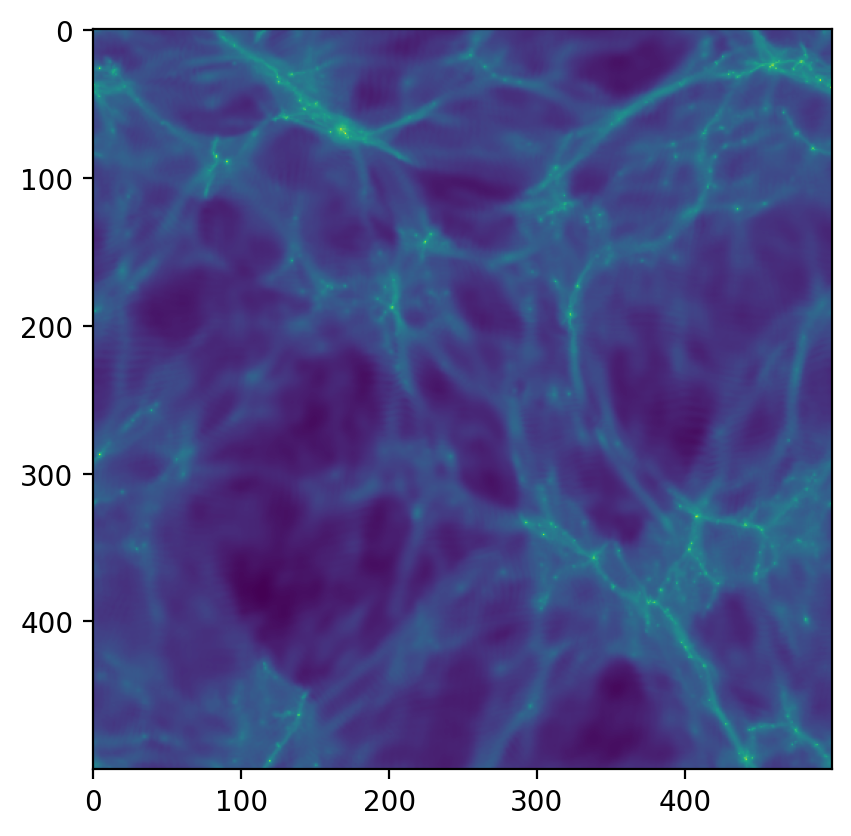

In [4]:
plt.figure()
plt.imshow(np.rot90(np.log10(A_grid)))
plt.show()

In [11]:
total_mass_sim = masses.sum()
total_mass_grid = A_grid.mean() * boxsize**2
print('Error on mass conservation:', abs(100 * (1-total_mass_sim / total_mass_grid)), '%')

Error on mass conservation: 0.9399511060584009 %


In [12]:
A       = ds.gas['temp'][mask]
A_grid  = Interpolator.query_field_at_positions(A, grid_2d)
A_grid  = A_grid.reshape((nx, nx))

Query: 	 querying values at coordinates


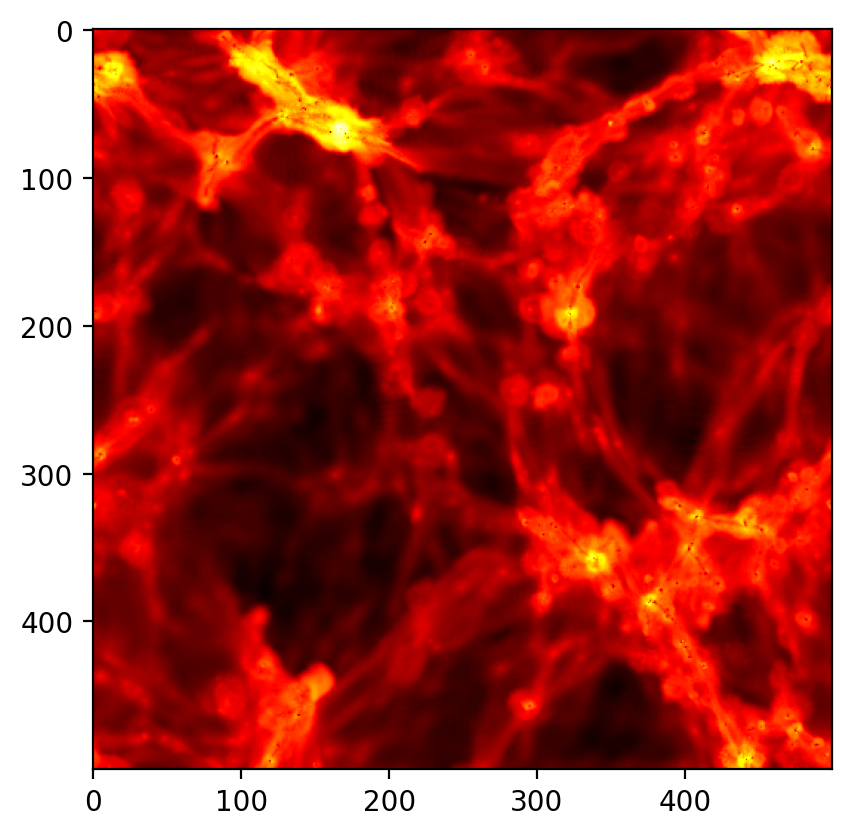

In [13]:
plt.figure()
plt.imshow(np.rot90(np.log10(A_grid)), cmap='hot')
plt.show()

#### Interpolation: 3d grid

In [14]:
ds = pn.load('../../../../../shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N128/snapshot_344.hdf5')

nx = 200
NN = 32

pos    = ds.gas['pos']
masses = ds.gas['mass']

Interpolator = sph_interpolator(pos, masses, boxsize, NN)

Init: 	 computing 3d hsm and ρ


In [15]:
grid_3d = create_grid_3d(nx, nx, nx, boxsize)

A       = Interpolator.rho
A_grid  = Interpolator.query_field_at_positions(A, grid_3d)
A_grid  = A_grid.reshape((nx, nx, nx))


Query: 	 querying values at coordinates


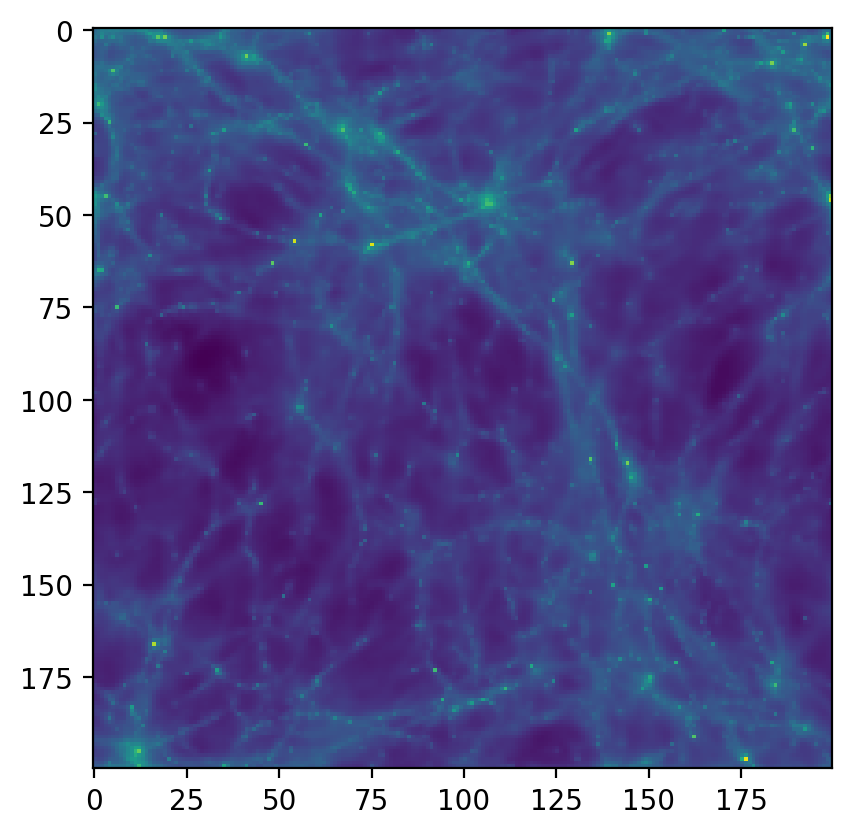

In [16]:
plt.figure()
plt.imshow(np.rot90(np.log10(A_grid.sum(axis=-1))))
plt.show()

In [17]:
total_mass_sim = masses.sum()
total_mass_grid = A_grid.mean() * boxsize**3

print('Error on mass conservation:', abs(100 * (1-total_mass_sim / total_mass_grid)), '%')

Error on mass conservation: 0.39708684243979775 %
